# NFL Gambling Project

## Overview

We have been task by John Daniels (local degenerate gambler) to make him a model that will predict the winner of NFL games. He specifically wants us to look at how the game day conditions effect the game.

## Business problem

#### Stakeholder: John Daniels
- non-technical stakeholder
- local gambling addict

#### True business problem: 
- predict whether the favorite in a NFL game wins or not
- explore factors that impact the result of the game

#### Deliverables: Inference or Prediction?
- Predition on if the favorite will win

#### Context:

- **False negative** Predicit favorite loses, but wins
    - **Outcome**: Lose money, by betting on underdog in this situation
- **False positive** preidcits favorite wins, but loses
    - **Outcome**: Lose money, by betting on favorite in this situation
    
Would prefer reducing fasle positives over false negative?
- equally would like to reduce false positives and false negatives.

### Evaluation Metric
Which metric would make sense to primarily use as we evaluate our models?

- Accuracy - balances the two kinds od errors (but is impractical with imbalanced targets)
- Precision - helps reduce false postives 
- Recall - helps reduce false negatives
- F1-Score - balances recall & precision (and is better than accuracy with imbalanced targets)
- ROC-AUC - helps focus better on probability outputs (makes sure our predicited probabilities are better)

All of these will be inportant measures fro evaulating our models.

# Data Processing

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn.naive_bayes import ComplementNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

In [2]:
def evaluate(model,Xtr,Xte,ytr,yte):
    train_preds = model.predict(Xtr)
    test_preds = model.predict(Xte)

    train_probas = model.predict_proba(Xtr)[:,1]
    test_probas = model.predict_proba(Xte)[:,1]
    
    plot_confusion_matrix(model,Xte,yte)
    
    plot_roc_curve(model,Xte,yte)
    
    print(f"Train Accuracy: {accuracy_score(ytr,train_preds):.4f}")
    print(f"Train F1: {f1_score(ytr,train_preds):.4f}")
    print(f"Train Precision: {precision_score(ytr,train_preds):.4f}")
    print(f"Train Recall: {recall_score(ytr,train_preds):.4f}")
    print(f"Train ROC-AUC: {roc_auc_score(ytr,train_probas):.4f}")
    print('*'*20)
    print(f"Test Accuracy: {accuracy_score(yte,test_preds):.4f}")
    print(f"Test F1: {f1_score(yte,test_preds):.4f}")
    print(f"Test Precision: {precision_score(yte,test_preds):.4f}")
    print(f"Test Recall: {recall_score(yte,test_preds):.4f}")
    print(f"Test ROC-AUC: {roc_auc_score(yte,test_probas):.4f}")

### Steps taken before this notebook

Lots of data preperatgion and cleaning steps were taken before this notebook, in another notebook. Here is a summary of the steps taken before the this notebook. Started off with limiting the data to the year 1979 and on because that is when gambling data starts. Also got rid of the superbowls because those are just different than the other games. Then got rid of any games that didn't actaully have a favorite. The first step into the cleaning process was to get two columns for the Home team's id and the away team's id. This was needed because the home team and away team was the team's full name, but the column that listed the favorite was their abbrviation. Then wrote a for loop that would take every game and determine who won, and made a new column of true or false if the favorite team won the game or not. Made a new column with if the favorite team was home. Merged that dataframe with the one about stadiums to get the elevations of the stadiums. Then hard encoded the elevation for the rest of the stadiums that had nulls for elevation. Used the elevations of the games to make a new column that gave the elevation change for the favorite team. Proceded to do the same thing for favorite team temperature change, wind difference, and humidity differnce. That is what lead us to have the dataframe below.

In [3]:
df = pd.read_csv('cleaned_nfl_data.csv')
df = df.drop(columns = ['Unnamed: 0'])
df

,schedule_season,team_home,team_away,team_favorite_id,spread_favorite,over_under_line,team_home_id,team_away_id,favorite_win,favorite_home,fav_elev_change,fav_temp_dif,fav_humidity_diff,fav_wind_diff
0,1979,Tampa Bay Buccaneers,Detroit Lions,TB,-3.0,30.0,TB,DET,True,True,0.0,0.000000,0.000000,0.000000
1,1979,Washington Redskins,Houston Oilers,TEN,-4.0,33.0,WAS,TEN,True,False,-1.8,8.000000,6.000000,11.000000
2,1979,St. Louis Cardinals,Dallas Cowboys,DAL,-4.0,37.0,ARI,DAL,True,False,25.6,-1.470588,13.020408,-1.102941
3,1979,Seattle Seahawks,San Diego Chargers,SEA,-2.0,42.5,SEA,LAC,False,True,0.0,0.000000,0.000000,0.000000
4,1979,New York Jets,Cleveland Browns,NYJ,-2.0,41.0,NYJ,CLE,False,True,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10414,2021,Tennessee Titans,Cincinnati Bengals,TEN,-4.0,48.5,TEN,CIN,False,True,0.0,0.000000,0.000000,0.000000
10415,2021,Kansas City Chiefs,Buffalo Bills,KC,-2.5,54.0,KC,BUF,True,True,0.0,0.000000,0.000000,0.000000
10416,2021,Tampa Bay Buccaneers,Los Angeles Rams,TB,-3.0,48.0,TB,LAR,False,True,0.0,0.000000,0.000000,0.000000
10417,2021,Kansas City Chiefs,Cincinnati Bengals,KC,-7.0,54.5,KC,CIN,False,True,0.0,0.000000,0.000000,0.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10419 entries, 0 to 10418
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   schedule_season    10419 non-null  int64  
 1   team_home          10419 non-null  object 
 2   team_away          10419 non-null  object 
 3   team_favorite_id   10419 non-null  object 
 4   spread_favorite    10419 non-null  float64
 5   over_under_line    10419 non-null  float64
 6   team_home_id       10419 non-null  object 
 7   team_away_id       10419 non-null  object 
 8   favorite_win       10419 non-null  bool   
 9   favorite_home      10419 non-null  bool   
 10  fav_elev_change    10419 non-null  float64
 11  fav_temp_dif       10419 non-null  float64
 12  fav_humidity_diff  10419 non-null  float64
 13  fav_wind_diff      10419 non-null  float64
dtypes: bool(2), float64(6), int64(1), object(5)
memory usage: 997.3+ KB


In [5]:
df.describe()

,schedule_season,spread_favorite,over_under_line,fav_elev_change,fav_temp_dif,fav_humidity_diff,fav_wind_diff
count,10419.000000,10419.000000,10419.000000,10419.000000,10419.000000,10419.000000,10419.000000
mean,2001.103369,-5.465496,42.201430,-11.572608,0.496212,-5.378007,-0.173608
std,12.194210,3.402057,4.795389,233.283006,9.948247,20.113000,3.802662
min,1979.000000,-26.500000,28.000000,-1610.200000,-67.797872,-86.500000,-13.573171
25%,1991.000000,-7.000000,38.500000,0.000000,0.000000,0.000000,0.000000
50%,2002.000000,-4.500000,42.000000,0.000000,0.000000,0.000000,0.000000
75%,2012.000000,-3.000000,45.000000,0.000000,0.000000,0.000000,0.000000
max,2021.000000,-1.000000,63.500000,1609.400000,49.946667,49.000000,23.000000


Below we are reading in the data we scrapped off the internet for the teams rankings.

In [6]:
df_1 = pd.read_csv('../Tom/pi.csv')
df_1

,Unnamed: 0,Rank,Team,Rating,v 1-5,v 6-10,v 11-16,Hi,Low,Last,Year
0,0,1,LA Rams (16-5),38.7,4-2,0-2,4-0,1,19,1,2022
1,1,2,San Francisco (12-8),35.7,3-1,2-2,1-3,2,26,2,2022
2,2,3,Kansas City (14-6),33.9,0-2,3-2,4-0,1,19,4,2022
3,3,4,Cincinnati (13-8),32.8,2-2,1-1,5-0,3,28,3,2022
4,4,5,Tampa Bay (14-5),30.8,0-2,3-0,1-2,1,15,5,2022
...,...,...,...,...,...,...,...,...,...,...,...
603,603,28,Washington (5-11),16.9,1-3,0-2,2-2,8,31,28,2004
604,604,29,LA Chargers (4-12),16.1,0-0,0-4,0-4,25,32,29,2004
605,605,30,Arizona (4-12),15.1,0-1,1-2,0-4,22,32,30,2004
606,606,31,Las Vegas (4-12),14.3,0-1,0-3,1-2,2,32,31,2004


In [7]:
df_1 = df_1.drop(columns = ['Rating','v 1-5','v 6-10','v 11-16','Hi','Low','Last','Unnamed: 0'])

In [8]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608 entries, 0 to 607
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Rank    608 non-null    int64 
 1   Team    608 non-null    object
 2   Year    608 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 14.4+ KB


In [9]:
df_1.describe()

,Rank,Year
count,608.000000,608.000000
mean,16.500000,2013.000000
std,9.240695,5.481735
min,1.000000,2004.000000
25%,8.750000,2008.000000
50%,16.500000,2013.000000
75%,24.250000,2018.000000
max,32.000000,2022.000000


Below is a bunch of cleaning up the names in the dataframe so they match with the original dataframe and we can merge them.

In [10]:
df['team_home'].str.split(" ").str[:-1].str.join(" ").unique()

array(['Tampa Bay', 'Washington', 'St. Louis', 'Seattle', 'New York',
       'New Orleans', 'Philadelphia', 'Los Angeles', 'Kansas City',
       'Denver', 'Chicago', 'Buffalo', 'Minnesota', 'New England',
       'San Francisco', 'Pittsburgh', 'San Diego', 'Green Bay', 'Miami',
       'Dallas', 'Cleveland', 'Cincinnati', 'Atlanta', 'Houston',
       'Detroit', 'Oakland', 'Baltimore', 'Indianapolis', 'Phoenix',
       'Arizona', 'Jacksonville', 'Carolina', 'Tennessee', 'Las Vegas',
       'Washington Football'], dtype=object)

In [11]:
df['team_home'].str.split(" ").str[-1].unique()

array(['Buccaneers', 'Redskins', 'Cardinals', 'Seahawks', 'Jets',
       'Saints', 'Eagles', 'Rams', 'Chiefs', 'Broncos', 'Bears', 'Bills',
       'Vikings', 'Patriots', 'Giants', '49ers', 'Steelers', 'Chargers',
       'Packers', 'Dolphins', 'Cowboys', 'Browns', 'Bengals', 'Falcons',
       'Oilers', 'Lions', 'Raiders', 'Colts', 'Jaguars', 'Panthers',
       'Ravens', 'Titans', 'Texans', 'Team'], dtype=object)

In [12]:
{" ".join(team.split(" ")[:-1]):team for team in df['team_home']}
#     team[:-1].join(" ") : team[-1]

{'Tampa Bay': 'Tampa Bay Buccaneers',
 'Washington': 'Washington Redskins',
 'St. Louis': 'St. Louis Rams',
 'Seattle': 'Seattle Seahawks',
 'New York': 'New York Giants',
 'New Orleans': 'New Orleans Saints',
 'Philadelphia': 'Philadelphia Eagles',
 'Los Angeles': 'Los Angeles Rams',
 'Kansas City': 'Kansas City Chiefs',
 'Denver': 'Denver Broncos',
 'Chicago': 'Chicago Bears',
 'Buffalo': 'Buffalo Bills',
 'Minnesota': 'Minnesota Vikings',
 'New England': 'New England Patriots',
 'San Francisco': 'San Francisco 49ers',
 'Pittsburgh': 'Pittsburgh Steelers',
 'San Diego': 'San Diego Chargers',
 'Green Bay': 'Green Bay Packers',
 'Miami': 'Miami Dolphins',
 'Dallas': 'Dallas Cowboys',
 'Cleveland': 'Cleveland Browns',
 'Cincinnati': 'Cincinnati Bengals',
 'Atlanta': 'Atlanta Falcons',
 'Houston': 'Houston Texans',
 'Detroit': 'Detroit Lions',
 'Oakland': 'Oakland Raiders',
 'Baltimore': 'Baltimore Ravens',
 'Indianapolis': 'Indianapolis Colts',
 'Phoenix': 'Phoenix Cardinals',
 'Arizona

In [13]:
df_1['Team'].unique();

In [14]:
map_1 = {" ".join(team.split(" ")[:-1]):team for team in df['team_home']}

In [15]:
map_1['Washington'] = map_1['Washington Football']
del map_1['Washington Football']

In [16]:
map_1

{'Tampa Bay': 'Tampa Bay Buccaneers',
 'Washington': 'Washington Football Team',
 'St. Louis': 'St. Louis Rams',
 'Seattle': 'Seattle Seahawks',
 'New York': 'New York Giants',
 'New Orleans': 'New Orleans Saints',
 'Philadelphia': 'Philadelphia Eagles',
 'Los Angeles': 'Los Angeles Rams',
 'Kansas City': 'Kansas City Chiefs',
 'Denver': 'Denver Broncos',
 'Chicago': 'Chicago Bears',
 'Buffalo': 'Buffalo Bills',
 'Minnesota': 'Minnesota Vikings',
 'New England': 'New England Patriots',
 'San Francisco': 'San Francisco 49ers',
 'Pittsburgh': 'Pittsburgh Steelers',
 'San Diego': 'San Diego Chargers',
 'Green Bay': 'Green Bay Packers',
 'Miami': 'Miami Dolphins',
 'Dallas': 'Dallas Cowboys',
 'Cleveland': 'Cleveland Browns',
 'Cincinnati': 'Cincinnati Bengals',
 'Atlanta': 'Atlanta Falcons',
 'Houston': 'Houston Texans',
 'Detroit': 'Detroit Lions',
 'Oakland': 'Oakland Raiders',
 'Baltimore': 'Baltimore Ravens',
 'Indianapolis': 'Indianapolis Colts',
 'Phoenix': 'Phoenix Cardinals',
 'Ar

In [17]:
df_1['Team'] = df_1['Team'].apply(lambda t: t.split('(')[0].strip())
df_1

,Rank,Team,Year
0,1,LA Rams,2022
1,2,San Francisco,2022
2,3,Kansas City,2022
3,4,Cincinnati,2022
4,5,Tampa Bay,2022
...,...,...,...
603,28,Washington,2004
604,29,LA Chargers,2004
605,30,Arizona,2004
606,31,Las Vegas,2004


In [18]:
list(df_1['Team'].sort_values().unique())

['Arizona',
 'Atlanta',
 'Baltimore',
 'Buffalo',
 'Carolina',
 'Chicago',
 'Cincinnati',
 'Cleveland',
 'Dallas',
 'Denver',
 'Detroit',
 'Green Bay',
 'Houston',
 'Indianapolis',
 'Jacksonville',
 'Kansas City',
 'LA Chargers',
 'LA Rams',
 'Las Vegas',
 'Miami',
 'Minnesota',
 'NY Giants',
 'NY Jets',
 'New England',
 'New Orleans',
 'Philadelphia',
 'Pittsburgh',
 'San Francisco',
 'Seattle',
 'Tampa Bay',
 'Tennessee',
 'Washington']

In [19]:
list(df.loc[df['schedule_season'] >=2003]['team_home'].sort_values().unique())

['Arizona Cardinals',
 'Atlanta Falcons',
 'Baltimore Ravens',
 'Buffalo Bills',
 'Carolina Panthers',
 'Chicago Bears',
 'Cincinnati Bengals',
 'Cleveland Browns',
 'Dallas Cowboys',
 'Denver Broncos',
 'Detroit Lions',
 'Green Bay Packers',
 'Houston Texans',
 'Indianapolis Colts',
 'Jacksonville Jaguars',
 'Kansas City Chiefs',
 'Las Vegas Raiders',
 'Los Angeles Chargers',
 'Los Angeles Rams',
 'Miami Dolphins',
 'Minnesota Vikings',
 'New England Patriots',
 'New Orleans Saints',
 'New York Giants',
 'New York Jets',
 'Oakland Raiders',
 'Philadelphia Eagles',
 'Pittsburgh Steelers',
 'San Diego Chargers',
 'San Francisco 49ers',
 'Seattle Seahawks',
 'St. Louis Rams',
 'Tampa Bay Buccaneers',
 'Tennessee Titans',
 'Washington Football Team',
 'Washington Redskins']

In [20]:
map_2 = ({'LA Rams':"Los Angeles Rams | St. Louis Rams",
          'LA Chargers':"Los Angeles Chargers | San Diego Chargers",
          'NY Giants':'New York Giants',
          'NY Jets':'New York Jets', 
          'Las Vegas': "Las Vegas Raiders | Oakland Raiders",
          'Washington': "Washington Football Team | Washington Redskins"})

In [21]:
map_1

{'Tampa Bay': 'Tampa Bay Buccaneers',
 'Washington': 'Washington Football Team',
 'St. Louis': 'St. Louis Rams',
 'Seattle': 'Seattle Seahawks',
 'New York': 'New York Giants',
 'New Orleans': 'New Orleans Saints',
 'Philadelphia': 'Philadelphia Eagles',
 'Los Angeles': 'Los Angeles Rams',
 'Kansas City': 'Kansas City Chiefs',
 'Denver': 'Denver Broncos',
 'Chicago': 'Chicago Bears',
 'Buffalo': 'Buffalo Bills',
 'Minnesota': 'Minnesota Vikings',
 'New England': 'New England Patriots',
 'San Francisco': 'San Francisco 49ers',
 'Pittsburgh': 'Pittsburgh Steelers',
 'San Diego': 'San Diego Chargers',
 'Green Bay': 'Green Bay Packers',
 'Miami': 'Miami Dolphins',
 'Dallas': 'Dallas Cowboys',
 'Cleveland': 'Cleveland Browns',
 'Cincinnati': 'Cincinnati Bengals',
 'Atlanta': 'Atlanta Falcons',
 'Houston': 'Houston Texans',
 'Detroit': 'Detroit Lions',
 'Oakland': 'Oakland Raiders',
 'Baltimore': 'Baltimore Ravens',
 'Indianapolis': 'Indianapolis Colts',
 'Phoenix': 'Phoenix Cardinals',
 'Ar

In [22]:
del map_1['Washington']
del map_1['St. Louis']
del map_1['New York']
del map_1['Los Angeles']
del map_1['San Diego']
del map_1['Oakland']
del map_1['Las Vegas']

In [23]:
map_1

{'Tampa Bay': 'Tampa Bay Buccaneers',
 'Seattle': 'Seattle Seahawks',
 'New Orleans': 'New Orleans Saints',
 'Philadelphia': 'Philadelphia Eagles',
 'Kansas City': 'Kansas City Chiefs',
 'Denver': 'Denver Broncos',
 'Chicago': 'Chicago Bears',
 'Buffalo': 'Buffalo Bills',
 'Minnesota': 'Minnesota Vikings',
 'New England': 'New England Patriots',
 'San Francisco': 'San Francisco 49ers',
 'Pittsburgh': 'Pittsburgh Steelers',
 'Green Bay': 'Green Bay Packers',
 'Miami': 'Miami Dolphins',
 'Dallas': 'Dallas Cowboys',
 'Cleveland': 'Cleveland Browns',
 'Cincinnati': 'Cincinnati Bengals',
 'Atlanta': 'Atlanta Falcons',
 'Houston': 'Houston Texans',
 'Detroit': 'Detroit Lions',
 'Baltimore': 'Baltimore Ravens',
 'Indianapolis': 'Indianapolis Colts',
 'Phoenix': 'Phoenix Cardinals',
 'Arizona': 'Arizona Cardinals',
 'Jacksonville': 'Jacksonville Jaguars',
 'Carolina': 'Carolina Panthers',
 'Tennessee': 'Tennessee Titans'}

In [24]:
df.loc[df['schedule_season'] >= 2004]['team_home'].unique()

array(['New England Patriots', 'Miami Dolphins', 'Washington Redskins',
       'St. Louis Rams', 'San Francisco 49ers', 'Pittsburgh Steelers',
       'Philadelphia Eagles', 'New Orleans Saints', 'New York Jets',
       'Houston Texans', 'Denver Broncos', 'Cleveland Browns',
       'Chicago Bears', 'Buffalo Bills', 'Minnesota Vikings',
       'Carolina Panthers', 'Tampa Bay Buccaneers', 'San Diego Chargers',
       'Oakland Raiders', 'New York Giants', 'Kansas City Chiefs',
       'Jacksonville Jaguars', 'Tennessee Titans', 'Detroit Lions',
       'Dallas Cowboys', 'Cincinnati Bengals', 'Baltimore Ravens',
       'Atlanta Falcons', 'Arizona Cardinals', 'Green Bay Packers',
       'Seattle Seahawks', 'Indianapolis Colts', 'Los Angeles Rams',
       'Los Angeles Chargers', 'Las Vegas Raiders',
       'Washington Football Team'], dtype=object)

In [25]:
map_2

{'LA Rams': 'Los Angeles Rams | St. Louis Rams',
 'LA Chargers': 'Los Angeles Chargers | San Diego Chargers',
 'NY Giants': 'New York Giants',
 'NY Jets': 'New York Jets',
 'Las Vegas': 'Las Vegas Raiders | Oakland Raiders',
 'Washington': 'Washington Football Team | Washington Redskins'}

In [26]:
df_1['Team'].map(map_1)

0                       NaN
1       San Francisco 49ers
2        Kansas City Chiefs
3        Cincinnati Bengals
4      Tampa Bay Buccaneers
               ...         
603                     NaN
604                     NaN
605       Arizona Cardinals
606                     NaN
607                     NaN
Name: Team, Length: 608, dtype: object

In [27]:
df_1['Team_Clean'] = df_1['Team'].replace(map_1)

In [28]:
df_1['Team_Clean'] = df_1['Team_Clean'].replace(map_2)

In [29]:
df_1['Team_Clean']

0                   Los Angeles Rams | St. Louis Rams
1                                 San Francisco 49ers
2                                  Kansas City Chiefs
3                                  Cincinnati Bengals
4                                Tampa Bay Buccaneers
                            ...                      
603    Washington Football Team | Washington Redskins
604         Los Angeles Chargers | San Diego Chargers
605                                 Arizona Cardinals
606               Las Vegas Raiders | Oakland Raiders
607                                   New York Giants
Name: Team_Clean, Length: 608, dtype: object

In [30]:
df_1['Team_Clean'] = df_1['Team_Clean'].str.split('|')

In [31]:
df_1 = df_1.explode(column='Team_Clean')

In [32]:
df_1['Team_Clean'] = df_1['Team_Clean'].str.strip()

In [33]:
df_1 = df_1.rename(columns = {'Team_Clean':'team_home','Year':'schedule_season','Rank':'rank_home'})
df_1

,rank_home,Team,schedule_season,team_home
0,1,LA Rams,2022,Los Angeles Rams
0,1,LA Rams,2022,St. Louis Rams
1,2,San Francisco,2022,San Francisco 49ers
2,3,Kansas City,2022,Kansas City Chiefs
3,4,Cincinnati,2022,Cincinnati Bengals
...,...,...,...,...
604,29,LA Chargers,2004,San Diego Chargers
605,30,Arizona,2004,Arizona Cardinals
606,31,Las Vegas,2004,Las Vegas Raiders
606,31,Las Vegas,2004,Oakland Raiders


In [34]:
df_1 = df_1.drop(columns = 'Team')

In [35]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 684 entries, 0 to 607
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   rank_home        684 non-null    int64 
 1   schedule_season  684 non-null    int64 
 2   team_home        684 non-null    object
dtypes: int64(2), object(1)
memory usage: 21.4+ KB


In [36]:
df_g = pd.merge(df, df_1,  how='left', on = ['team_home','schedule_season'])
df_g

,schedule_season,team_home,team_away,team_favorite_id,spread_favorite,over_under_line,team_home_id,team_away_id,favorite_win,favorite_home,fav_elev_change,fav_temp_dif,fav_humidity_diff,fav_wind_diff,rank_home
0,1979,Tampa Bay Buccaneers,Detroit Lions,TB,-3.0,30.0,TB,DET,True,True,0.0,0.000000,0.000000,0.000000,NaN
1,1979,Washington Redskins,Houston Oilers,TEN,-4.0,33.0,WAS,TEN,True,False,-1.8,8.000000,6.000000,11.000000,NaN
2,1979,St. Louis Cardinals,Dallas Cowboys,DAL,-4.0,37.0,ARI,DAL,True,False,25.6,-1.470588,13.020408,-1.102941,NaN
3,1979,Seattle Seahawks,San Diego Chargers,SEA,-2.0,42.5,SEA,LAC,False,True,0.0,0.000000,0.000000,0.000000,NaN
4,1979,New York Jets,Cleveland Browns,NYJ,-2.0,41.0,NYJ,CLE,False,True,0.0,0.000000,0.000000,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10414,2021,Tennessee Titans,Cincinnati Bengals,TEN,-4.0,48.5,TEN,CIN,False,True,0.0,0.000000,0.000000,0.000000,15.0
10415,2021,Kansas City Chiefs,Buffalo Bills,KC,-2.5,54.0,KC,BUF,True,True,0.0,0.000000,0.000000,0.000000,2.0
10416,2021,Tampa Bay Buccaneers,Los Angeles Rams,TB,-3.0,48.0,TB,LAR,False,True,0.0,0.000000,0.000000,0.000000,1.0
10417,2021,Kansas City Chiefs,Cincinnati Bengals,KC,-7.0,54.5,KC,CIN,False,True,0.0,0.000000,0.000000,0.000000,2.0


Must do the same thing again but with different names so it makes away team columns this time.

In [37]:
df_1 = df_1.rename(columns = {'team_home':'team_away','rank_home':'rank_away'})
df_1

,rank_away,schedule_season,team_away
0,1,2022,Los Angeles Rams
0,1,2022,St. Louis Rams
1,2,2022,San Francisco 49ers
2,3,2022,Kansas City Chiefs
3,4,2022,Cincinnati Bengals
...,...,...,...
604,29,2004,San Diego Chargers
605,30,2004,Arizona Cardinals
606,31,2004,Las Vegas Raiders
606,31,2004,Oakland Raiders


In [38]:
df_1.team_away = df_1.team_away.str.strip()

In [39]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 684 entries, 0 to 607
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   rank_away        684 non-null    int64 
 1   schedule_season  684 non-null    int64 
 2   team_away        684 non-null    object
dtypes: int64(2), object(1)
memory usage: 21.4+ KB


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10419 entries, 0 to 10418
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   schedule_season    10419 non-null  int64  
 1   team_home          10419 non-null  object 
 2   team_away          10419 non-null  object 
 3   team_favorite_id   10419 non-null  object 
 4   spread_favorite    10419 non-null  float64
 5   over_under_line    10419 non-null  float64
 6   team_home_id       10419 non-null  object 
 7   team_away_id       10419 non-null  object 
 8   favorite_win       10419 non-null  bool   
 9   favorite_home      10419 non-null  bool   
 10  fav_elev_change    10419 non-null  float64
 11  fav_temp_dif       10419 non-null  float64
 12  fav_humidity_diff  10419 non-null  float64
 13  fav_wind_diff      10419 non-null  float64
dtypes: bool(2), float64(6), int64(1), object(5)
memory usage: 997.3+ KB


In [41]:
df_t = pd.merge(df_g, df_1,  how='left', on = ['team_away','schedule_season'])
df_t

,schedule_season,team_home,team_away,team_favorite_id,spread_favorite,over_under_line,team_home_id,team_away_id,favorite_win,favorite_home,fav_elev_change,fav_temp_dif,fav_humidity_diff,fav_wind_diff,rank_home,rank_away
0,1979,Tampa Bay Buccaneers,Detroit Lions,TB,-3.0,30.0,TB,DET,True,True,0.0,0.000000,0.000000,0.000000,NaN,NaN
1,1979,Washington Redskins,Houston Oilers,TEN,-4.0,33.0,WAS,TEN,True,False,-1.8,8.000000,6.000000,11.000000,NaN,NaN
2,1979,St. Louis Cardinals,Dallas Cowboys,DAL,-4.0,37.0,ARI,DAL,True,False,25.6,-1.470588,13.020408,-1.102941,NaN,NaN
3,1979,Seattle Seahawks,San Diego Chargers,SEA,-2.0,42.5,SEA,LAC,False,True,0.0,0.000000,0.000000,0.000000,NaN,NaN
4,1979,New York Jets,Cleveland Browns,NYJ,-2.0,41.0,NYJ,CLE,False,True,0.0,0.000000,0.000000,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10414,2021,Tennessee Titans,Cincinnati Bengals,TEN,-4.0,48.5,TEN,CIN,False,True,0.0,0.000000,0.000000,0.000000,15.0,28.0
10415,2021,Kansas City Chiefs,Buffalo Bills,KC,-2.5,54.0,KC,BUF,True,True,0.0,0.000000,0.000000,0.000000,2.0,3.0
10416,2021,Tampa Bay Buccaneers,Los Angeles Rams,TB,-3.0,48.0,TB,LAR,False,True,0.0,0.000000,0.000000,0.000000,1.0,10.0
10417,2021,Kansas City Chiefs,Cincinnati Bengals,KC,-7.0,54.5,KC,CIN,False,True,0.0,0.000000,0.000000,0.000000,2.0,28.0


Must make it 2004 and on. We do this because we only want seasons that we have rankings for and we are using the previous years rankings for that season, and the first year with these rankings is 2003, which means we use it for 2004.

In [42]:
df_t = df_t.loc[df_t['schedule_season'] >= 2004]
df_t

,schedule_season,team_home,team_away,team_favorite_id,spread_favorite,over_under_line,team_home_id,team_away_id,favorite_win,favorite_home,fav_elev_change,fav_temp_dif,fav_humidity_diff,fav_wind_diff,rank_home,rank_away
5698,2004,New England Patriots,Indianapolis Colts,NE,-3.0,44.5,NE,IND,True,True,0.00,0.000000,0.00,0.000000,1.0,2.0
5699,2004,Miami Dolphins,Tennessee Titans,TEN,-3.0,38.0,MIA,TEN,True,False,-174.10,8.272727,14.84,8.060606,6.0,3.0
5700,2004,Washington Redskins,Tampa Bay Buccaneers,WAS,-2.5,38.5,WAS,TB,True,True,0.00,0.000000,0.00,0.000000,28.0,18.0
5701,2004,St. Louis Rams,Arizona Cardinals,LAR,-11.0,46.0,LAR,ARI,True,True,0.00,0.000000,0.00,0.000000,9.0,30.0
5702,2004,San Francisco 49ers,Atlanta Falcons,ATL,-3.0,44.5,SF,ATL,True,False,-317.64,-7.338028,11.75,18.366197,19.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10414,2021,Tennessee Titans,Cincinnati Bengals,TEN,-4.0,48.5,TEN,CIN,False,True,0.00,0.000000,0.00,0.000000,15.0,28.0
10415,2021,Kansas City Chiefs,Buffalo Bills,KC,-2.5,54.0,KC,BUF,True,True,0.00,0.000000,0.00,0.000000,2.0,3.0
10416,2021,Tampa Bay Buccaneers,Los Angeles Rams,TB,-3.0,48.0,TB,LAR,False,True,0.00,0.000000,0.00,0.000000,1.0,10.0
10417,2021,Kansas City Chiefs,Cincinnati Bengals,KC,-7.0,54.5,KC,CIN,False,True,0.00,0.000000,0.00,0.000000,2.0,28.0


In [43]:
home_team_id = list(df_t['team_home_id'].values)
fav_team_id = list(df_t['team_favorite_id'].values)
away_team_id = list(df_t['team_away_id'].values)

In [44]:
rank_home = list(df_t['rank_home'].values)
rank_away = list(df_t['rank_away'].values)

In [45]:
fav_rank_diff = []
for index in list(range(0,4721)):
    if home_team_id[index] == fav_team_id[index]:
        fav_rank_diff.append(rank_away[index] - rank_home[index])
    elif away_team_id[index] == fav_team_id[index]:
        fav_rank_diff.append(rank_home[index] - rank_away[index])

In [46]:
fav_rank_diff;

In [47]:
df_t['fav_rank_diff'] = fav_rank_diff
df_t

<ipython-input-47-e0f6588f1015>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['fav_rank_diff'] = fav_rank_diff


,schedule_season,team_home,team_away,team_favorite_id,spread_favorite,over_under_line,team_home_id,team_away_id,favorite_win,favorite_home,fav_elev_change,fav_temp_dif,fav_humidity_diff,fav_wind_diff,rank_home,rank_away,fav_rank_diff
5698,2004,New England Patriots,Indianapolis Colts,NE,-3.0,44.5,NE,IND,True,True,0.00,0.000000,0.00,0.000000,1.0,2.0,1.0
5699,2004,Miami Dolphins,Tennessee Titans,TEN,-3.0,38.0,MIA,TEN,True,False,-174.10,8.272727,14.84,8.060606,6.0,3.0,3.0
5700,2004,Washington Redskins,Tampa Bay Buccaneers,WAS,-2.5,38.5,WAS,TB,True,True,0.00,0.000000,0.00,0.000000,28.0,18.0,-10.0
5701,2004,St. Louis Rams,Arizona Cardinals,LAR,-11.0,46.0,LAR,ARI,True,True,0.00,0.000000,0.00,0.000000,9.0,30.0,21.0
5702,2004,San Francisco 49ers,Atlanta Falcons,ATL,-3.0,44.5,SF,ATL,True,False,-317.64,-7.338028,11.75,18.366197,19.0,14.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10414,2021,Tennessee Titans,Cincinnati Bengals,TEN,-4.0,48.5,TEN,CIN,False,True,0.00,0.000000,0.00,0.000000,15.0,28.0,13.0
10415,2021,Kansas City Chiefs,Buffalo Bills,KC,-2.5,54.0,KC,BUF,True,True,0.00,0.000000,0.00,0.000000,2.0,3.0,1.0
10416,2021,Tampa Bay Buccaneers,Los Angeles Rams,TB,-3.0,48.0,TB,LAR,False,True,0.00,0.000000,0.00,0.000000,1.0,10.0,9.0
10417,2021,Kansas City Chiefs,Cincinnati Bengals,KC,-7.0,54.5,KC,CIN,False,True,0.00,0.000000,0.00,0.000000,2.0,28.0,26.0


Above we are making the new column that has the difference in last season rank from the favorite in the game.

In [48]:
df_t.columns

Index(['schedule_season', 'team_home', 'team_away', 'team_favorite_id',
       'spread_favorite', 'over_under_line', 'team_home_id', 'team_away_id',
       'favorite_win', 'favorite_home', 'fav_elev_change', 'fav_temp_dif',
       'fav_humidity_diff', 'fav_wind_diff', 'rank_home', 'rank_away',
       'fav_rank_diff'],
      dtype='object')

In [49]:
df_f = df_t.drop(columns = ['team_home','team_away',
                     'team_favorite_id','team_home_id','team_away_id',
                     'rank_home','rank_away'])
df_f

,schedule_season,spread_favorite,over_under_line,favorite_win,favorite_home,fav_elev_change,fav_temp_dif,fav_humidity_diff,fav_wind_diff,fav_rank_diff
5698,2004,-3.0,44.5,True,True,0.00,0.000000,0.00,0.000000,1.0
5699,2004,-3.0,38.0,True,False,-174.10,8.272727,14.84,8.060606,3.0
5700,2004,-2.5,38.5,True,True,0.00,0.000000,0.00,0.000000,-10.0
5701,2004,-11.0,46.0,True,True,0.00,0.000000,0.00,0.000000,21.0
5702,2004,-3.0,44.5,True,False,-317.64,-7.338028,11.75,18.366197,5.0
...,...,...,...,...,...,...,...,...,...,...
10414,2021,-4.0,48.5,False,True,0.00,0.000000,0.00,0.000000,13.0
10415,2021,-2.5,54.0,True,True,0.00,0.000000,0.00,0.000000,1.0
10416,2021,-3.0,48.0,False,True,0.00,0.000000,0.00,0.000000,9.0
10417,2021,-7.0,54.5,False,True,0.00,0.000000,0.00,0.000000,26.0


In [50]:
#df_f.to_csv('final_nfl_data.csv')

Now we are finally ready to model!!

In [51]:
X = df_f.drop(columns = ['schedule_season','favorite_win'])
y = df_f['favorite_win']

In [52]:
test_df = df_f.loc[df_f['schedule_season'] >=2019]

In [53]:
len(test_df)/len(df_f)

0.1688201652192332

Doing a normal train test split, but making the testing data the last 2 seasons and then making a holding set of the last 50 games to see at the end how much money we would have made on those games.

In [54]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=len(test_df), random_state=42,shuffle = False)

X_test, X_hold, y_test, y_hold = train_test_split(X_test, y_test, test_size=50, shuffle=False)

In [55]:
X_train.head()

,spread_favorite,over_under_line,favorite_home,fav_elev_change,fav_temp_dif,fav_humidity_diff,fav_wind_diff,fav_rank_diff
5698,-3.0,44.5,True,0.00,0.000000,0.00,0.000000,1.0
5699,-3.0,38.0,False,-174.10,8.272727,14.84,8.060606,3.0
5700,-2.5,38.5,True,0.00,0.000000,0.00,0.000000,-10.0
5701,-11.0,46.0,True,0.00,0.000000,0.00,0.000000,21.0
5702,-3.0,44.5,False,-317.64,-7.338028,11.75,18.366197,5.0


In [56]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3924 entries, 5698 to 9621
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   spread_favorite    3924 non-null   float64
 1   over_under_line    3924 non-null   float64
 2   favorite_home      3924 non-null   bool   
 3   fav_elev_change    3924 non-null   float64
 4   fav_temp_dif       3924 non-null   float64
 5   fav_humidity_diff  3924 non-null   float64
 6   fav_wind_diff      3924 non-null   float64
 7   fav_rank_diff      3924 non-null   float64
dtypes: bool(1), float64(7)
memory usage: 249.1 KB


In [57]:
X_train.describe()

,spread_favorite,over_under_line,fav_elev_change,fav_temp_dif,fav_humidity_diff,fav_wind_diff,fav_rank_diff
count,3924.000000,3924.000000,3924.000000,3924.000000,3924.000000,3924.000000,3924.000000
mean,-5.472350,43.712666,-16.444128,1.193499,-5.272502,-0.389982,4.656218
std,3.430243,4.824191,245.633394,9.804083,19.513631,3.689116,11.904682
min,-26.500000,30.000000,-1610.200000,-67.797872,-83.576923,-12.866667,-31.000000
25%,-7.000000,40.500000,0.000000,0.000000,0.000000,0.000000,-3.000000
50%,-4.500000,43.500000,0.000000,0.000000,0.000000,0.000000,5.000000
75%,-3.000000,47.000000,0.000000,0.000000,0.000000,0.000000,13.000000
max,-1.000000,63.500000,1609.100000,49.946667,48.555556,22.907407,31.000000


In [58]:
train_df = X_train.copy()
train_df['favorite_win'] = y_train

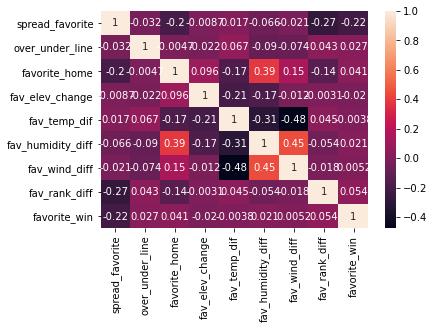

In [59]:
sns.heatmap(train_df.corr(),annot = True);

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


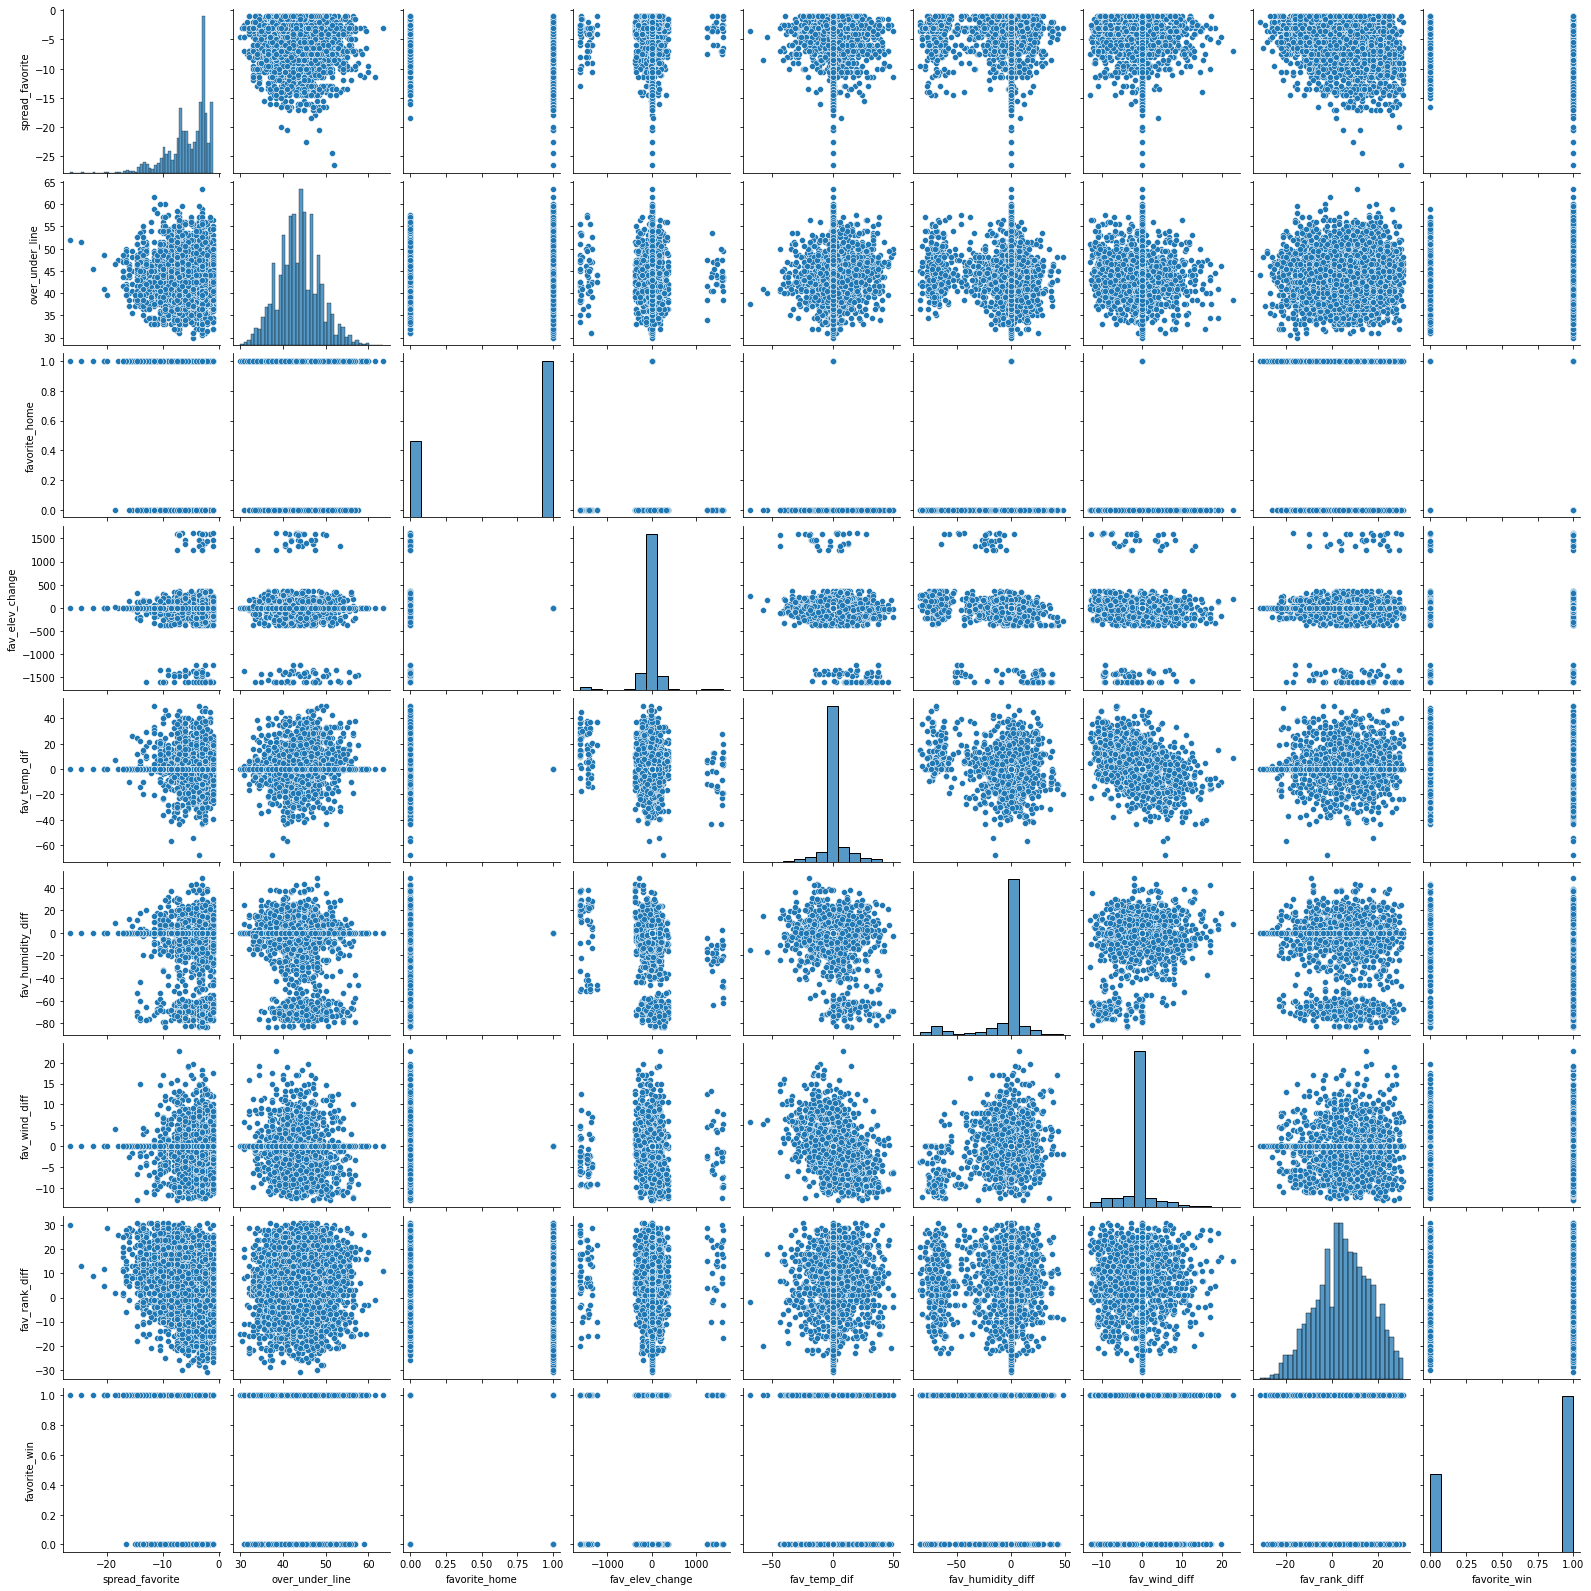

In [60]:
sns.pairplot(train_df);

### EDA Observations:

Any initial findings?

- no one category seems to have immense correlation to our traget



## Initial Modeling

### Model-less Baseline

In [61]:
pd.Series(y_train).value_counts(normalize = True)

True     0.666157
False    0.333843
Name: favorite_win, dtype: float64

#### Evaluate:

- if we predict that favorite wins everygame, we'd be right about 66% of the time
- class imbalance

### Model 1:  Logisitic Regression

In [62]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [63]:
logreg = LogisticRegression(random_state = 42)

logreg.fit(X_train_sc,y_train)

LogisticRegression(random_state=42)

Train Accuracy: 0.6636
Train F1: 0.7962
Train Precision: 0.6675
Train Recall: 0.9862
Train ROC-AUC: 0.6383
********************
Test Accuracy: 0.6479
Test F1: 0.7846
Test Precision: 0.6508
Test Recall: 0.9876
Test ROC-AUC: 0.6590


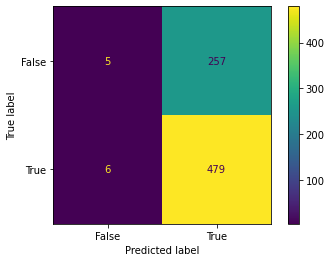

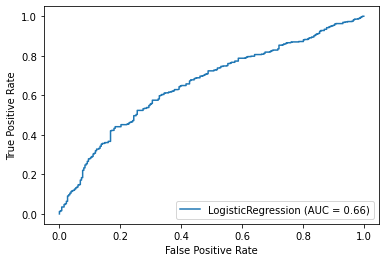

In [64]:
evaluate(logreg,X_train_sc,X_test_sc,y_train,y_test)

When looking at this, it is very clear we have imbalance. Now with that said, it isn't the worst, but isn't the best. Our train accuracy is almost the excat same as the baseline model and the test accuracy is worse. That isn't great, so logistic probably isn't the right model.

### Model 2:  Decision Tree

In [65]:
tree = DecisionTreeClassifier(random_state = 42,max_depth = 5)

tree.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

Train Accuracy: 0.6713
Train F1: 0.8017
Train Precision: 0.6702
Train Recall: 0.9973
Train ROC-AUC: 0.6641
********************
Test Accuracy: 0.6319
Test F1: 0.7737
Test Precision: 0.6438
Test Recall: 0.9691
Test ROC-AUC: 0.6080


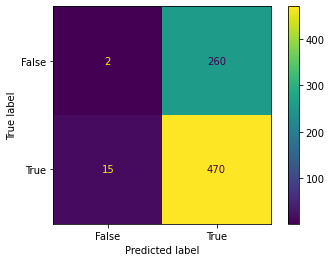

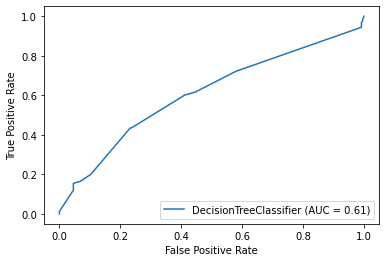

In [66]:
evaluate(tree,X_train,X_test,y_train,y_test)

Almost the same as our logistic model, but our train accuracy is slightly better while our test accuracy is actually slightly smaller.

### Model 3:  Naive Bayes

In [67]:
clf_nb = Pipeline(steps = [
    ('scaler', StandardScaler()),
    ('naive_bayes', GaussianNB()),
])

clf_nb.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('naive_bayes', GaussianNB())])

Train Accuracy: 0.6389
Train F1: 0.7674
Train Precision: 0.6720
Train Recall: 0.8944
Train ROC-AUC: 0.6085
********************
Test Accuracy: 0.6171
Test F1: 0.7487
Test Precision: 0.6524
Test Recall: 0.8784
Test ROC-AUC: 0.5955


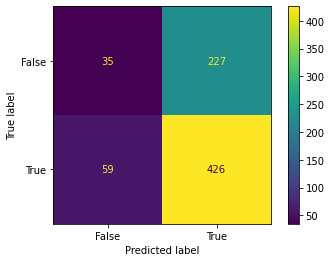

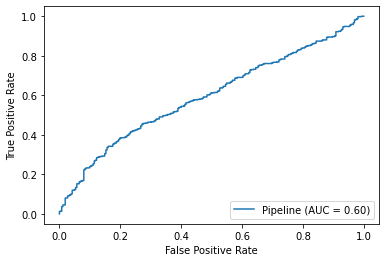

In [68]:
evaluate(clf_nb,X_train,X_test,y_train,y_test)

This is the worst model by far. Worst accuracy for both test and train.

### Model 4:  Random Forest

In [69]:
smote = SMOTE(random_state=42
X_train, y_train = smote.fit_resample(X_train,y_train)

In [70]:
clf_rf = Pipeline(steps = [
    ('scaler', StandardScaler()),
    ('random forest', RandomForestClassifier(random_state=42,max_depth = 10)),
])

clf_rf.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('random forest',
                 RandomForestClassifier(max_depth=10, random_state=42))])

In [71]:
cross_val_score(clf_rf,X_train,y_train, scoring='accuracy')

array([0.58795411, 0.61854685, 0.64435946, 0.66889952, 0.66794258])

In [72]:
cross_validate(clf_rf,X_train,y_train,scoring='accuracy',return_train_score = True)

{'fit_time': array([0.2970829 , 0.29557037, 0.28753304, 0.28533292, 0.2839601 ]),
 'score_time': array([0.01415491, 0.0143218 , 0.01434779, 0.01414108, 0.01419902]),
 'test_score': array([0.58795411, 0.61854685, 0.64435946, 0.66889952, 0.66794258]),
 'train_score': array([0.77881396, 0.77259684, 0.76303204, 0.75543868, 0.7650012 ])}

Train Accuracy: 0.7580
Train F1: 0.7360
Train Precision: 0.8098
Train Recall: 0.6744
Train ROC-AUC: 0.8588
********************
Test Accuracy: 0.6145
Test F1: 0.6793
Test Precision: 0.7385
Test Recall: 0.6289
Test ROC-AUC: 0.6351


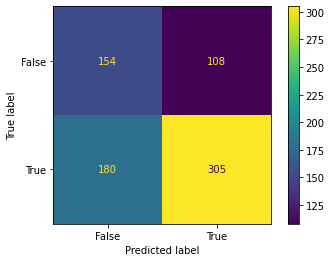

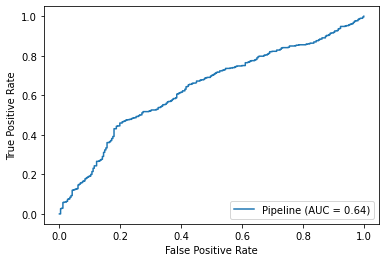

In [73]:
evaluate(clf_rf,X_train,X_test,y_train,y_test)

Clearly overfitting, not much else to deem from it until we lower the over fitting.

### Model 5:  Random Forest with Grid Search

In [74]:
param_grid = {
    "random forest__criterion":['gini','entropy'],
    "random forest__max_depth": [1,2,3,4,5,10,15],
    "random forest__min_samples_leaf": [1,2,5,10,12,15],
    "random forest__min_samples_split": [2,4,6,8]
}

In [75]:
clf_rf = Pipeline(steps = [
    ('scaler', StandardScaler()),
    ('random forest', RandomForestClassifier(random_state=42)),
])

clf_rf.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('random forest', RandomForestClassifier(random_state=42))])

In [76]:
gs = GridSearchCV(clf_rf,param_grid,cv = 5,scoring = 'accuracy')

gs.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('random forest',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'random forest__criterion': ['gini', 'entropy'],
                         'random forest__max_depth': [1, 2, 3, 4, 5, 10, 15],
                         'random forest__min_samples_leaf': [1, 2, 5, 10, 12,
                                                             15],
                         'random forest__min_samples_split': [2, 4, 6, 8]},
             scoring='accuracy')

In [77]:
gs.best_params_

{'random forest__criterion': 'gini',
 'random forest__max_depth': 15,
 'random forest__min_samples_leaf': 1,
 'random forest__min_samples_split': 2}

In [78]:
gs.best_score_

0.670447272361331

This is the best score we have with the model that logically makes the most since. Now when we look below, it is still overfitting, but our scores are the best, and with no time left in the project, it is the one we are going with.

Train Accuracy: 0.8491
Train F1: 0.8450
Train Precision: 0.8684
Train Recall: 0.8229
Train ROC-AUC: 0.9409
********************
Test Accuracy: 0.6225
Test F1: 0.7025
Test Precision: 0.7192
Test Recall: 0.6866
Test ROC-AUC: 0.6277


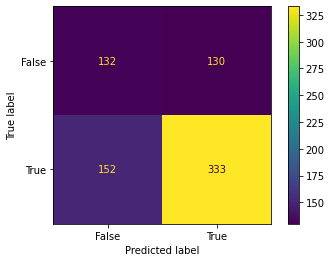

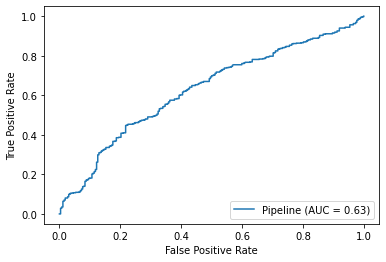

In [79]:
evaluate(gs.best_estimator_,X_train,X_test,y_train,y_test)

In [80]:
y_hold.values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False, False, False,  True,  True, False,  True,
       False,  True,  True,  True,  True, False,  True,  True, False,
       False,  True, False, False,  True])

In [81]:
gs.best_estimator_.predict_proba(X_hold)[16]

array([0.56654101, 0.43345899])

In [82]:
type(gs.best_estimator_.predict_proba(X_hold)[7][1].round(2)*100)

numpy.float64

In [83]:
gs.best_estimator_.predict_proba(X_hold)[7].max().round(2)*100

56.00000000000001

In [84]:
gs.best_estimator_.predict_proba(X_hold)[0][1]

0.6964178187944428

In [85]:
gs.best_estimator_.predict_proba(X_hold)[0][1].round(2)*100

70.0

In [86]:
accuracy_score(y_hold,gs.best_estimator_.predict(X_hold))

0.66

In [87]:
X_hold['spread_favorite'].median()

-6.5

Below we are going to calculate how much money the baseline would have made over the last 50 games versus our model.

In [88]:
the_stupid_bag = 0
for index in list(range(0,len(y_hold))):
    if y_hold.values[index] == True:
        the_stupid_bag += 35.71
    elif y_hold.values[index] == False:
        the_stupid_bag -= 100
the_stupid_bag

-114.4400000000002

In [89]:
the_bag = 0
for index in list(range(0,len(y_hold))):
    if y_hold.values[index] == True:
        if gs.best_estimator_.predict_proba(X_hold)[index].max().round(2) == gs.best_estimator_.predict_proba(X_hold)[index][1].round(2):
            the_bag += 35.71
        elif gs.best_estimator_.predict_proba(X_hold)[index].max().round(2) == gs.best_estimator_.predict_proba(X_hold)[index][0].round(2):
            the_bag -= 100
    if y_hold.values[index] == False:
        if gs.best_estimator_.predict_proba(X_hold)[index].max().round(2) == gs.best_estimator_.predict_proba(X_hold)[index][1].round(2):
            the_bag -= 100
        elif gs.best_estimator_.predict_proba(X_hold)[index].max().round(2) == gs.best_estimator_.predict_proba(X_hold)[index][0].round(2):
            the_bag += 225
the_bag

424.8799999999999

In [90]:
the_bag - the_stupid_bag

539.32

As you can see, our model preformed better than the baseline. With this said, \\$424.88 might seem like a lot of money, but the fact that this is saying you put down \\$100 50 times, that isn't a great return to risk value. With that said, in gambling, there is no perfect, but there is doing better. 

# Conclusion

We have made a model that will predict whether or not the favorite will win. Even though it has about the same accuracy as the baseline model, the times it accurately predicts the favorite to lose and you bet on the underdog, it makes up for the times it is wrong becasue you get bigger payouts for betting on the underdog. With that said, this model has lots of future work that needs to happen to it, if it is to be fully trusted. Future work would entail the following: emplemting player data (injuries, position ranks,ect), momentum (is a team on a winning streak), if its a division/rivalary game, is the game a playoff game (or is it a must win to make the playoffs), home field advantage ranking for the teams, and coaching ranking.